In [1]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import requests

In [2]:
TOTAL_FUNDING = 8_000_000
MAX_CAP = 1_000_000
MIN_CAP = 10_000

In [3]:
# placeholder for making API calls

KEY = 'your_key'
CURSOR = 0
f"""
curl -X 'GET' \
  'https://vote.optimism.io/api/v1/retrofunding/rounds/5/projects?limit=100&offset={CURSOR}&category=all' \
  -H 'accept: application/json' \
  -H 'Authorization: Bearer {KEY}'
"""

print("Fetch the data...")

Fetch the data...


In [4]:
synthetic_data = json.load(open("data/rf5_synthetic_ballots.json"))
synthetic_data[-2]

{'voter_id': '0x3d1f2b3b6be449c6b58ba2d7f6f78d741f7dcca1',
 'budget': 2250000,
 'category_assignment': 'eth_core',
 'category_allocations': {'eth_core': 29.879978503612588,
  'op_tooling': 25.401564459306144,
  'op_rnd': 44.718457037081265},
 'project_allocations': {'0x82ef80ecf81b0bab897fe9ab595544db44b14708993f91c5f5f457f869d2af1d': 0.0,
  '0xbdc75c7f2d9d4f797174656b47ef920cc968b82a1235efec4a37816fc8077ef9': 6.312743072075623,
  '0xdda0798a5eb762366cd5aa5de87f042567946b47f5cf1d776077a2b00d75c575': 0.0,
  '0xd7f9140cd24d5332f81c9a12d5d7da80f0c61f69db015073727064f0b975c875': 1.9952551195310064,
  '0xf615a763fa6599d40e52ee2e15ec77f208324c5863a157cdeb243639936476e8': 0.0,
  '0x383672f18d21daf99befe6f41d201f357f70f1883daba5260ac992413edd1ba2': 2.8919126219371885,
  '0x73deb2a75792f7c688dc87a3080ce18637b7d241ad2b551272fb21aee72d6bf7': 0.0,
  '0x762c363ac739a057eb4d414fd17916a2b098a00c7ddeae32d021f6df572561e1': 4.713293804721525,
  '0x29e10fc68e78b9b22e5c088a87a2779f918c5c47fff3ccf58dcb02ae

In [5]:
NUM_VOTERS = len(synthetic_data)
CATEGORIES = list(synthetic_data[-1]['category_allocations'].keys())
NUM_CATEGORIES = len(CATEGORIES)
PROJECTS = list(set([p for vote in synthetic_data for p in vote['project_allocations'].keys()]))
NUM_PROJECTS = len(PROJECTS)
print(CATEGORIES)

['eth_core', 'op_tooling', 'op_rnd']


In [6]:
# Step 0. Parse all the ballots (and remove null votes)
budget_votes = []
category_scores = defaultdict(list)
project_scores = defaultdict(lambda: defaultdict(list))
for ballot in synthetic_data:
    budget_votes.append(ballot['budget'])
    assigned_category = ballot['category_assignment']
    for category, category_percentage in ballot['category_allocations'].items():
        category_scores[category].append(category_percentage)

    for project, project_percentage in ballot['project_allocations'].items():
        if project_percentage:
            project_scores[assigned_category][project].append(project_percentage)

# Step 1A. Calculate total funding for the round based on median budget vote
total_budget = np.median(budget_votes)

# Step 1B. Calculate medians for categories and normalize to weights across categories
category_medians = {k: np.median(v)/100 for k, v in category_scores.items()}    
category_total = sum(category_medians.values())
category_weights = {k: v/category_total for k, v in category_medians.items()}

# Step 2. Calculate medians for projects and normalize to weights within a category
project_weights = defaultdict(lambda: defaultdict(list))
for category, project_dict in project_scores.items():
    for project, scores in project_dict.items():
        project_weights[category][project] = np.median(scores) / 100
    category_subtotal = sum(project_weights[category].values())
    for k, v in project_weights[category].items():
        project_weights[category][k] = v/category_subtotal 

# Step 3. Create an initial series of project funding allocations
initial_project_allocations = pd.Series()
for category, projects in project_weights.items():
    for project, score in projects.items():
        initial_project_allocations.loc[project] = score * category_weights[category] #* total_budget

# Check the results makes sense
print("\nMedian Budget:", total_budget)
for c in CATEGORIES:
    print("\nCategory:", c)
    print("-----------------")
    print(f"Median Allocation: {category_weights[c]*100:.1f}%")
    print("Total Projects:", len(project_weights[c]))
    print(f"Check: Sum of Project Allocations Within Category: {sum(project_weights[c].values())*100:.1f}%\n")
print("******************")    
print(f"\nCheck: Sum of Project Allocations Across All Categories: {initial_project_allocations.sum()*100:.1f}%")


Median Budget: 7225000.0

Category: eth_core
-----------------
Median Allocation: 31.3%
Total Projects: 46
Check: Sum of Project Allocations Within Category: 100.0%


Category: op_tooling
-----------------
Median Allocation: 33.4%
Total Projects: 40
Check: Sum of Project Allocations Within Category: 100.0%


Category: op_rnd
-----------------
Median Allocation: 35.2%
Total Projects: 34
Check: Sum of Project Allocations Within Category: 100.0%

******************

Check: Sum of Project Allocations Across All Categories: 100.0%


Final Results:
 - Projects: 120
 - Voters: 100
 - Funding Available: 7225000.0
 - Funding Awarded: 7225000


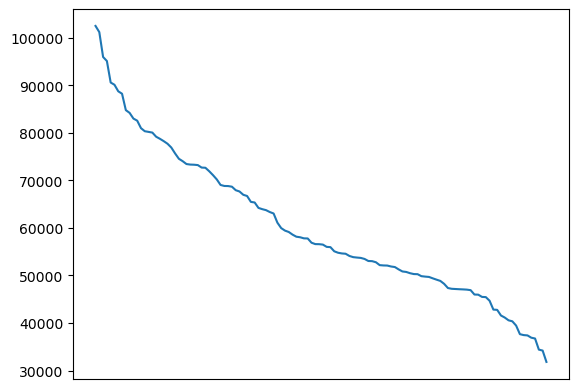

In [7]:
def allocate_funding(project_scores, funding_balance):
    """
    Helper for allocating and redistributing funding balances
    """
    score_balance = project_scores.sum()
    allocations = pd.Series()
    
    for project, score in project_scores.sort_values(ascending=False).items():
        uncapped_funding_alloc = score / score_balance * funding_balance
        capped_funding_alloc = min(uncapped_funding_alloc, MAX_CAP)
        allocations.loc[project] = capped_funding_alloc
        funding_balance -= capped_funding_alloc
        score_balance -= score

    return allocations


# Step 4. Implement max cap and redistribute excess
capped_allocations = allocate_funding(initial_project_allocations, total_budget)

# Step 5. Set the funding for projects below the minimum cap to 0
capped_allocations.loc[capped_allocations < MIN_CAP] = 0

# Step 6. Allocate the remaining funding to projects below the maximum cap
max_cap_funding = capped_allocations[capped_allocations == MAX_CAP].sum()
remaining_funding = total_budget - max_cap_funding
remaining_projects = capped_allocations[capped_allocations < MAX_CAP]
capped_allocations.update(allocate_funding(remaining_projects, funding_balance=remaining_funding))

capped_allocations.to_csv('data/rf5_synthetic_ballots_results.csv', header=['allocation'])

# Check the results
capped_allocations.plot(xticks=[])
print("Final Results:")
print(" - Projects:", NUM_PROJECTS)
print(" - Voters:", NUM_VOTERS)
print(" - Funding Available:", total_budget)
print(" - Funding Awarded:", round(capped_allocations.sum()))